In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [6]:
base_dir = '/kaggle/input/utkface-new/UTKFace'

In [7]:
image_paths = [] 
age_labels = [] 
gender_labels = []


for filename in tqdm(os.listdir(base_dir)):
    image_path = os.path.join(base_dir, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender =int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
# 0 = Male, 1=Female
df = pd.DataFrame()
df['image'], df['age'],df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [9]:
gender_dict = {0:'Male',
              1:'Female'}

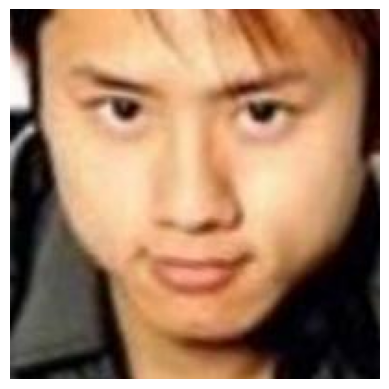

In [10]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

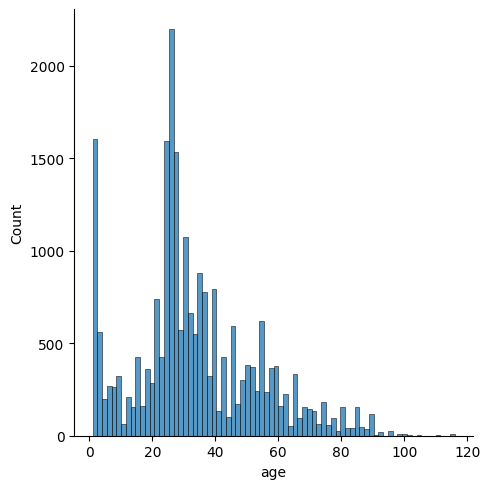

In [11]:
sns.displot(df['age']);

<Axes: xlabel='gender', ylabel='count'>

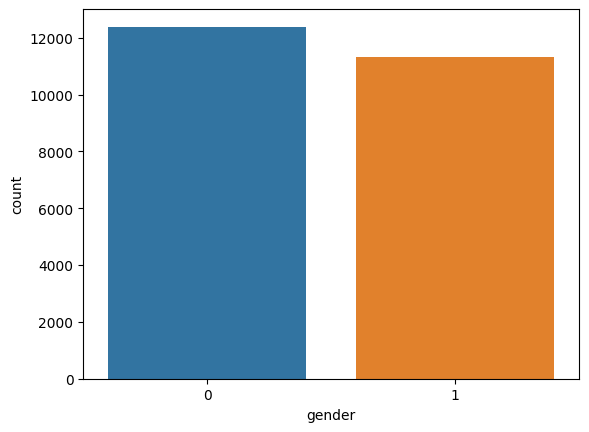

In [12]:
sns.countplot(x=(df['gender']))

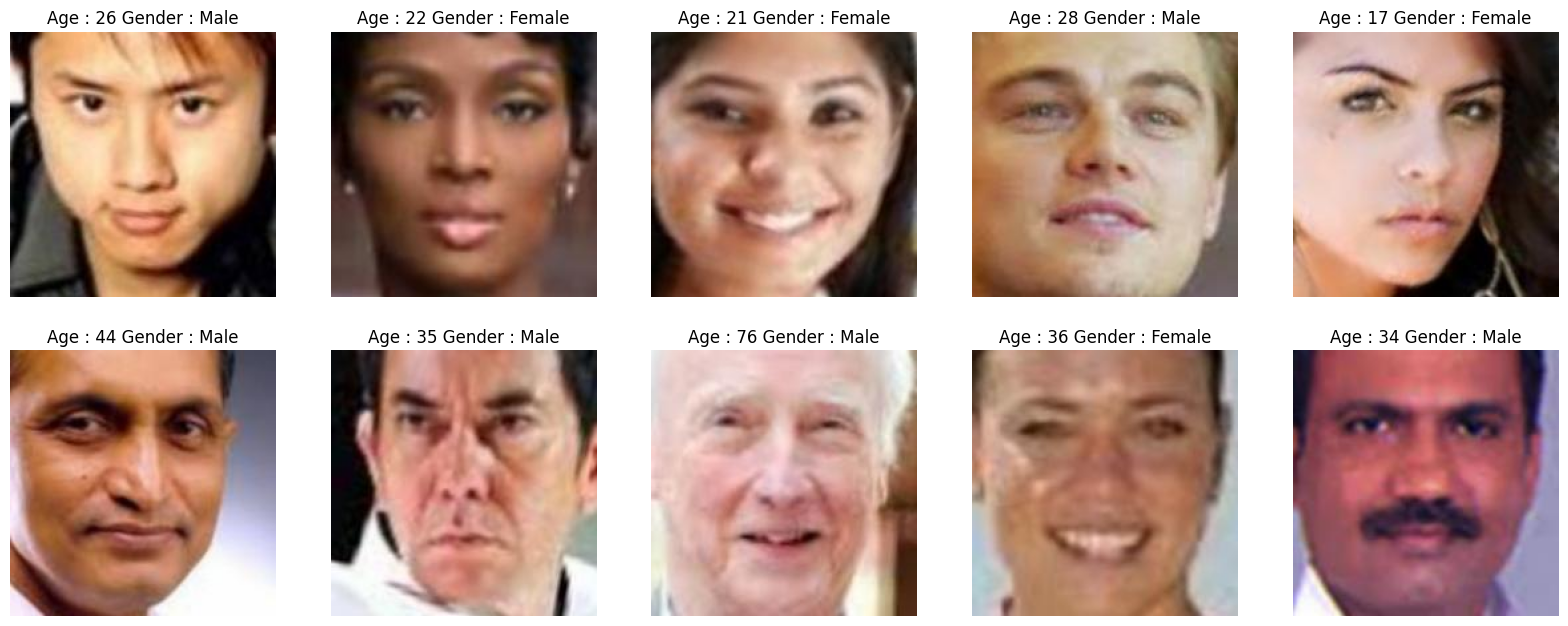

In [13]:
plt.figure(figsize=(20,20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'Age : {age} Gender : {gender_dict[gender]}')
    plt.axis('off')

In [14]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features),128,128,3) # privious is 128 128 3
    return features

In [15]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [16]:
X.shape

(23708, 128, 128, 3)

In [17]:
X = X/255.0

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [19]:
input_shape = (128,128,3)

In [20]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3,3), activation = 'relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3,3), activation = 'relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3,3), activation = 'relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3,3), activation = 'relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation = 'relu') (flatten)
dense_2 = Dense(256, activation = 'relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation = 'linear', name = 'age_out') (dropout_2) # privious is relu

model = Model(inputs = [inputs], outputs = [output_1, output_2])

model.compile(
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    optimizer='Adam',
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,108,034 (19.49 MB)

 Trainable params: 5,108,034 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size = 64, epochs=5, validation_split = 0.2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - age_out_mae: 17.1507 - gender_out_accuracy: 0.5126 - loss: 17.8796 - val_age_out_mae: 14.5779 - val_gender_out_accuracy: 0.6170 - val_loss: 15.2533
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - age_out_mae: 12.9185 - gender_out_accuracy: 0.6717 - loss: 13.5304 - val_age_out_mae: 10.3912 - val_gender_out_accuracy: 0.7644 - val_loss: 10.8896
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - age_out_mae: 10.5771 - gender_out_accuracy: 0.7757 - loss: 11.0498 - val_age_out_mae: 9.7131 - val_gender_out_accuracy: 0.8174 - val_loss: 10.1061
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - age_out_mae: 9.2993 - gender_out_accuracy: 0.8107 - loss: 9.7057 - val_age_out_mae: 8.3493 - val_gender_out_accuracy: 0.8326 - val_loss: 8.7119
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - age_out_mae: 8.2308 - gender_out_accuracy: 0.8378 - loss: 8.5891 - val_age_out_mae: 8.0642 - val_gender_out_accuracy: 0.8530 - val_loss: 8.3921

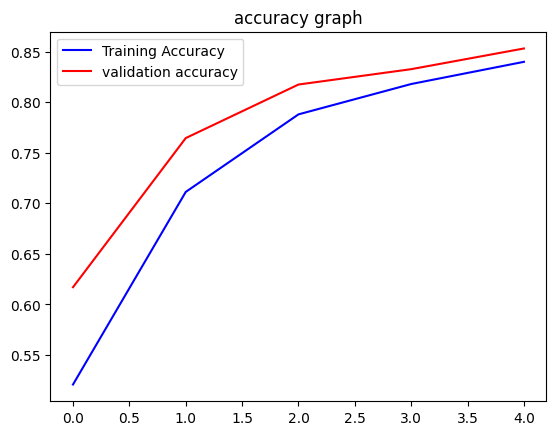

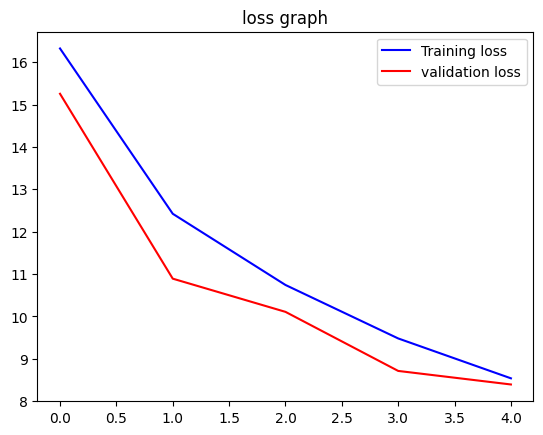

In [23]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'validation accuracy')
plt.title('accuracy graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'validation loss')
plt.title('loss graph')
plt.legend()
plt.show()

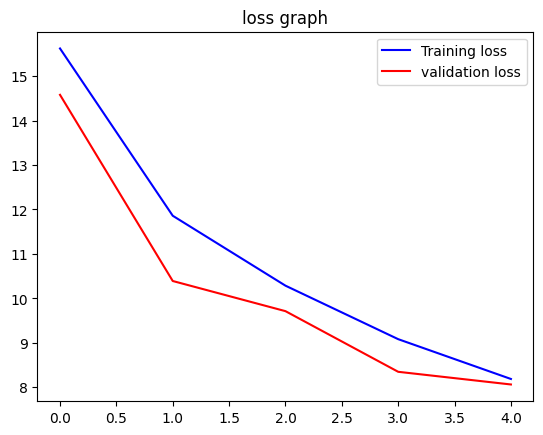

In [24]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'validation loss')
plt.title('loss graph')
plt.legend()
plt.show()


Orignal Gender: Female 
 orignal age :  18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
predicted gender: Female 
 predicted age: 27


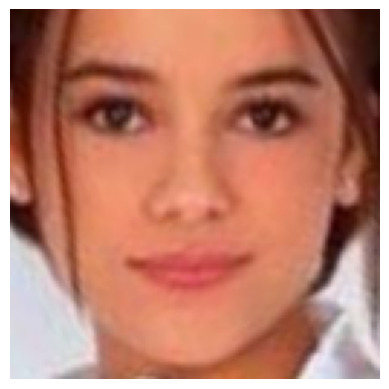

In [25]:
image_index = 10
print('Orignal Gender:',gender_dict[y_gender[image_index]],'\n', 'orignal age : ',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('predicted gender:',pred_gender,'\n','predicted age:',pred_age)
plt.imshow(X[image_index].reshape(128,128,3))
plt.axis('off');

Orignal Gender: Female 
 orignal age :  21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted gender: Female 
 predicted age: 19


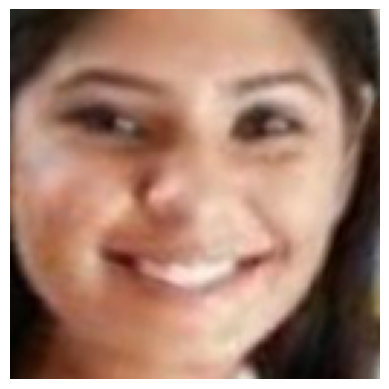

In [26]:
image_index = 2
print('Orignal Gender:',gender_dict[y_gender[image_index]],'\n', 'orignal age : ',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('predicted gender:',pred_gender,'\n','predicted age:',pred_age)
plt.imshow(X[image_index].reshape(128,128,3))
plt.axis('off');

Orignal Gender: Female 
 orignal age :  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted gender: Female 
 predicted age: 1


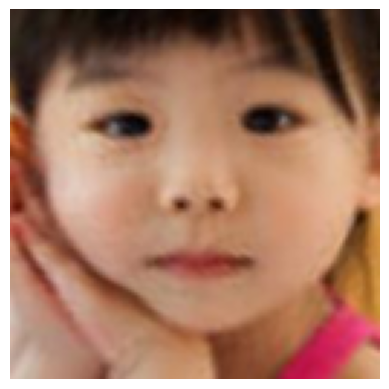

In [27]:
image_index = 100
print('Orignal Gender:',gender_dict[y_gender[image_index]],'\n', 'orignal age : ',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,128,128,3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('predicted gender:',pred_gender,'\n','predicted age:',pred_age)
plt.imshow(X[image_index].reshape(128,128,3))
plt.axis('off');